In [87]:
%load_ext autoreload
%autoreload 2

from nb_003 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'caltech101'

# Create validation set

In [94]:
class FilesDataset(Dataset):
    def __init__(self, fns, labels, classes=None):
        if classes is None: classes = list(set(labels))
        self.classes = classes
        self.class2idx = {v:k for k,v in enumerate(classes)}
        self.fns = fns
        self.y = [self.class2idx[o] for o in labels]
        
    @classmethod
    def from_folder(cls, folder, classes=None, test_pct=0.):
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
            
        fns,labels = [],[]
        for cl in classes:
            fnames = get_image_files(folder/cl)
            fns += fnames
            labels += [cl] * len(fnames)
            
        if test_pct==0.: return cls(fns, labels)
        fns,labels = np.array(fns),np.array(labels)
        is_test = np.random.uniform(size=(len(fns),)) < test_pct
        return cls(fns[~is_test], labels[~is_test]), cls(fns[is_test], labels[is_test])

    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [120]:
classes = ['airplanes','Motorbikes','Faces','watch','Leopards']
np.random.seed(42)
train_ds,valid_ds = FilesDataset.from_folder(PATH, classes=classes, test_pct=0.2)

x = lambda: valid_ds[500][0]

In [121]:
len(train_ds),len(valid_ds)

(1951, 521)

## TransformBunch

In [185]:
@reg_transform
def crop(x, size, row_pct:uniform, col_pct:uniform) -> TfmType.Final:
    size = listify(size,2)
    rows,cols = size
    if x.size(1)<rows or x.size(2)<cols:
#         set_trace()
        row_pad = max((rows-x.size(1)+1)//2, 0)
        col_pad = max((cols-x.size(2)+1)//2, 0)
        x = F.pad(x[None], (col_pad,col_pad,row_pad,row_pad), mode='reflect')[0]
    row = int((x.size(1)-rows)*row_pct)
    col = int((x.size(2)-cols)*col_pct)

    res = x[:, row:row+rows, col:col+cols]
#     print(res.size())
#     if res.shape[1:] != (150,150): set_trace()
    return res

In [188]:
tfms = [
    crop_tfm(size=100)
]

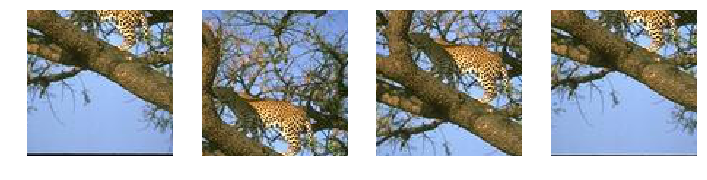

In [189]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(resolve_pipeline(tfms)(x()), ax)

In [42]:
train_tfms = [
    flip_lr_tfm(p=0.5),
    rotate_tfm(degrees=(-10,10.), p=0.5),
    zoom_tfm(scale=(0.9,1.1), p=0.5),
    contrast_tfm(scale=(0.8,1.2)),
    brightness_tfm(change=(0.4,0.6)),
    crop_tfm()
]

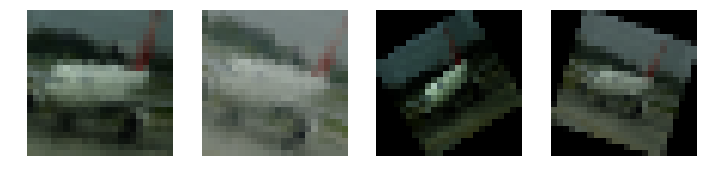

In [47]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(resolve_pipeline(tfms, size=24, padding_mode='zeros')(x()), ax)

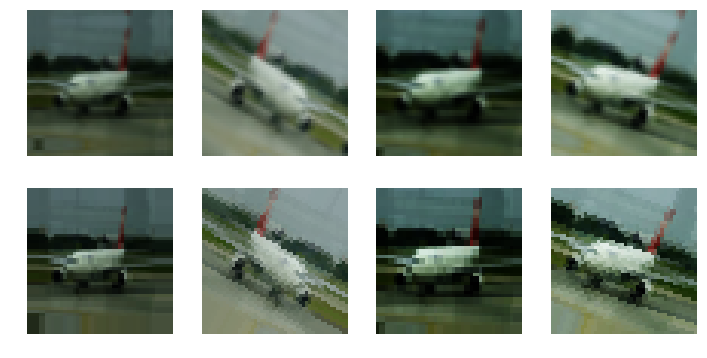

In [48]:
tfms = [flip_lr_tfm(p=0.5),
        rotate_tfm(degrees=(-45,45.), p=0.5),
        zoom_tfm(scale=(0.75,1.5), p=0.5),
        contrast_tfm(scale=(0.5,2.0)),
        brightness_tfm(change=(0.3,0.7))
]

_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    tfm = resolve_pipeline(tfms, size=48)
    show_image(tfm(x()), axes[0][i])
    show_image(tfm(x(), mode='nearest'), axes[1][i])

## CIFAR augmentation

In [49]:
@reg_transform
def pad(x, padding, mode='reflect') -> TfmType.Pixel:
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@reg_transform
def crop(x, size, row_pct:uniform, col_pct:uniform) -> TfmType.Final:
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows)*row_pct)
    col = int((x.size(2)-cols)*col_pct)
    return x[:, row:row+rows, col:col+cols]

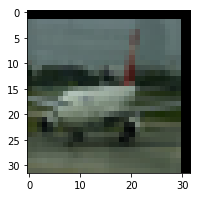

In [50]:
show_image(crop(pad(x(), 4, 'constant'), 32, 0.25, 0.75), hide_axis=False)

In [51]:
tfms = [flip_lr_tfm(p=0.5),
        pad_tfm(padding=4, mode='constant'),
        crop_tfm(size=32)]

In [52]:
from dataclasses import dataclass
from typing import Any, Collection, Callable

In [53]:
@dataclass
class TfmDataset(Dataset):
    ds: Dataset
    tfms: Collection[Callable]
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self,idx):
        x,y = self.ds[idx]
        return resolve_pipeline(tfms)(x),y

In [54]:
train_tds = TfmDataset(train_ds, tfms)

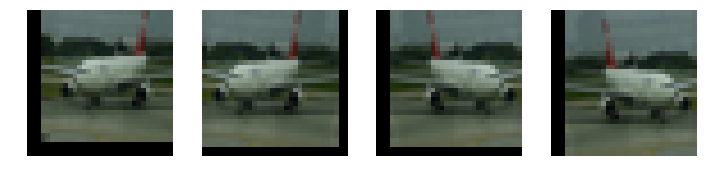

In [55]:
_,axes = plt.subplots(1,4, figsize=(12,9))
for ax in axes.flat: show_image(train_tds[1][0], ax)

## CIFAR training

In [56]:
data_mean = torch.tensor([0.49, 0.48, 0.45]).to(default_device)
data_std = torch.tensor([0.25, 0.24, 0.26]).to(default_device)

In [57]:
batch_transforms = xy_transforms([partial(normalize, data_mean, data_std)])

In [58]:
bs=64

In [59]:
data = DataBunch(train_tds, valid_ds, bs=bs, train_tfms=batch_transforms, valid_tfms=batch_transforms)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [60]:
x_,y_ = next(iter(data.train_dl))
x_ = denormalize(data_mean, data_std, x_).clamp(0,1.)

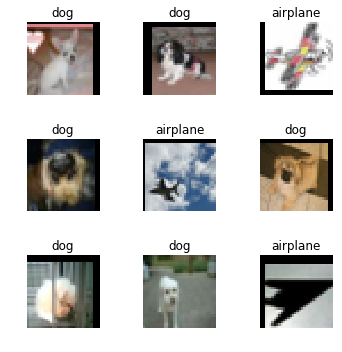

In [61]:
show_images(x_,y_,3,train_ds.classes, figsize=(5,5))

In [62]:
learn = Learner(data, simple_cnn([3,16,16,2], [3,3,3], [2,2,2]))

In [65]:
learn.fit(2, 0.1)

0 0.29228833317756653


1 0.27624186539649964

